# Semantic Segmentation of Satellite Images 

The task here is to segment the satellite images by training a deep neural network and outputting per-pixel mask of the image.  

## Importing Libraries 

In [1]:
import cv2
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from random import randint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D,ReLU, concatenate, BatchNormalization,MaxPooling2D, Dropout,Conv2DTranspose, UpSampling2D
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import plot_model
from osgeo import gdal




### Important parameters to define the training and testing data

In [2]:
n_channels =3
n_train = 400
n_valid = 100
n_test = 30

## Data Preparation

Images are in .tif format. We start by looking at number of bands in the input image and extract only bands 4,3,2 if we want to train model on RGB images else we extract all bands and convert it into an array

In [3]:
def raster2img(img_data):
    bands_count= img_data.RasterCount
    
    if n_channels==3:
        r = img_data.GetRasterBand(4)
        g = img_data.GetRasterBand(3)
        b = img_data.GetRasterBand(2)
        
        r = r.ReadAsArray()
        g = g.ReadAsArray()
        b = b.ReadAsArray()
        
        img = np.dstack((r,g,b))
        out = np.zeros_like(img).astype(np.float32)
        n = img.shape[2]
        for i in range(n):
            a,b = 0,1
            c = np.percentile(img[:,:,i],2)
            d = np.percentile(img[:,:,i],98)
            t = a+(img[:,:,i]-c)*(b-a)/(d-c)
            t[t<a] = a
            t[t>b] = b
            out[:,:,i] = t
    
    elif n_channels==12:
        img = np.zeros([64,64,bands_count])
        out = np.zeros_like(img).astype(np.float32)
        for i in range(bands_count):
            data = img_data.GetRasterBand(1)
            img[:,:,i] = data.ReadAsArray(0,0,img_data.RasterXSize,img_data.RasterYSize)

            a,b = 0,1
            c = np.percentile(img[:,:,i],2)
            d = np.percentile(img[:,:,i],98)
            t = a+(img[:,:,i]-c)*(b-a)/(d-c)
            t[t<a] = a
            t[t>b] = b

            out[:,:,i] = t
        
    return out

Now we want to split the images for training, validation and testing. We split in ratio of 80:20. A function is defined to split the images and the path has to be specified before hand

In [4]:
def images_split(total_images_path,n_train,n_valid,n_test):
    total_images = []
    count = 0
    if count <530:
        count = count + 1 

        for file in glob.iglob(total_images_path+'**/*.tif',recursive=True):
            
            image = gdal.Open(file, gdal.GA_ReadOnly)
            output_image = raster2img(image)
            total_images.append(output_image)
    
    total_images_count = len(total_images)
    total_images = np.asarray(total_images)
    X_train = []
    X_valid = []
    X_test = []

    for i in range(0,n_train):
        X_train.append(total_images[i])

    for i in range(n_train,n_train+n_valid):
        X_valid.append(total_images[i])

    for i in range(n_train+n_valid,n_train+n_valid+n_test):
        X_test.append(total_images[i])
    
    X_train = np.asarray(X_train)
    X_valid = np.asarray(X_valid)
    X_test = np.asarray(X_test)

    return X_train,X_valid,X_test
    

In [5]:
total_images_path= 'D:/vision_impulse/images/'
X_train, X_valid, X_test = images_split(total_images_path,n_train,n_valid,n_test)

Like Images the labels are also in .tif format. But labels are single banded images. So we extract that solo band and convert to image of 1 channel.

In [6]:
def raster2label(img_data):
    bands_count = img_data.RasterCount
    if bands_count ==1:
        gray = img_data.GetRasterBand(1)

        gray1 = gray.ReadAsArray()

        label = np.asarray(gray1)
        
    return label

In [7]:
def labels_split(total_labels_path,n_train,n_valid,n_test):
    total_labels = []
    count = 0
    if count < 530:
        count = count + 1
        for file in glob.iglob(total_labels_path+'**/*.tif',recursive=True):
            label = gdal.Open(file, gdal.GA_ReadOnly)
            g = label.GetRasterBand(1)
            g = label.ReadAsArray()
            g = g.reshape((64,64,1))
        #print(g)        
        #output_label = raster2label(label)

            total_labels.append(g)
    
    total_label_count = len(total_labels)
    total_labels = np.asarray(total_labels)

    y_train = []
    y_valid = []
    y_test = []

    for i in range(0,n_train):
        l = total_labels[i]
        l = tf.keras.utils.to_categorical(l,3)
        y_train.append(l)

    for i in range(n_train,n_train+n_valid):
        l = total_labels[i]
        l = tf.keras.utils.to_categorical(l,3)
        y_valid.append(l)

    for i in range(n_train+n_valid,n_train+n_valid+n_test):
        l = total_labels[i]
        l = tf.keras.utils.to_categorical(l,3)
        y_test.append(l)
    
    y_train = np.asarray(y_train)
    y_valid = np.asarray(y_valid)
    y_test = np.asarray(y_test)

    return y_train,y_valid,y_test


In [8]:
total_labels_path = 'D:/vision_data_duplicate/vision_impulse/labels/'
y_train, y_valid, y_test = labels_split(total_labels_path,n_train,n_valid,n_test)

Just to make sure if the sizes of both images and labels are equal we use assert and check if they are of same size.

In [9]:
assert X_train.shape[0] == y_train.shape[0]
print(f'X_train and y_train are of same length : {X_train.shape[0]}')

X_train and y_train are of same length : 400


Finally we print the shapes and sizes of the images and labels in all the category splits.

In [10]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(400, 64, 64, 3)
(100, 64, 64, 3)
(30, 64, 64, 3)
(400, 64, 64, 3)
(100, 64, 64, 3)
(30, 64, 64, 3)


It is well-known that matplotlib cannot plot a 12 channel image. So, in case of working with 12 channel image, we visualize predicted image label and actual label. If the image is RGB we visualize input image, input label and predicted image.

In [11]:
def visualize(viz_list):

    if n_channels ==3:
        plt.figure(figsize=(15,15))
        title = ['Input_image', 'Input_mask', 'predicted_mask']
        for i in range(len(viz_list)):
            plt.subplot(1,len(viz_list), i+1)
            plt.title(title[i])
            plt.imshow(viz_list[i])
            plt.axis('off')
        plt.show()
        
    else:
        plt.figure(figsize=(15,15))
        title = ['input_mask','predicted_mask']
        for i in range(len(viz_list)):
            plt.subplot(1,len(viz_list),i+1)
            plt.title(title[i])
            plt.imshow(viz_list[i])
            plt.axis('off')
        plt.show()
    

27


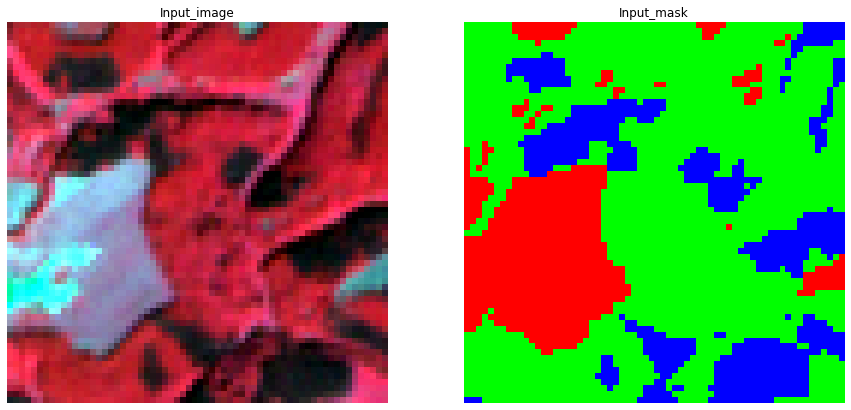

In [12]:
rand_num = randint(0,len(X_train))
print(rand_num)
visualize([X_train[rand_num],y_train[rand_num]])

## Building Models and picking the model

In coming blocks I built multiple models like a vanilla U-Net model, a DeepLabv3 model and a U_net model pre trained and with image net weights along with VGG encoder. 

For u_net with VGG encoder, we extract particular blocks from it and downsample the image followed by upsampling the model.

In [13]:
def upsample(filters, size, strides):
    """Upsample the input"""

    initializer = tf.random_normal_initializer(0., 0.02)

    result = Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=strides,
                                      padding="same",
                                      kernel_initializer=initializer,
                                      use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
   
    result.add(tf.keras.layers.ReLU())
    return result


base_model = VGG19(input_shape=(64,64,n_channels), include_top=False, weights="imagenet")

layers_names = [
    "block2_conv1",    
    "block2_conv2",    
    "block3_conv1",    
    "block3_conv2",    
    "block4_conv1",    
    "block4_conv2",    
    "block5_conv1",    
]

layers = [base_model.get_layer(name).output for name in layers_names]
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False


up_stack = [
    upsample(512, 3, 1),   
    upsample(512, 3, 2),   
    upsample(256, 3, 1),    
    upsample(256, 3, 2),   
    upsample(128, 3, 1),   
    upsample(128, 3, 2),  
]     

def unet_vgg(output_channels=3):
    input_lr = tf.keras.layers.Input(shape= (64,64,n_channels))
    x = input_lr

    initializer = tf.random_normal_initializer(0., 0.02)
    output = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2, activation='sigmoid',
        padding="same", kernel_initializer=initializer
    )
    
    concat = tf.keras.layers.Concatenate()

    # Downsampling 
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connection
    for up, skip in zip (up_stack, skips):
        x = up(x)
        if up.layers[0].strides == (2, 2):
            concat = tf.keras.layers.Concatenate()
            x = concat([x, skip])

    x = output(x)
    model = Model(inputs=input_lr,outputs=x)
    return model


Now we are constructing the architecture of DeepLabv3 and we need to make AtrousPyramid Block first.

In [14]:
def AtrousPyramid(model_input):
    dims = tf.keras.backend.int_shape(model_input)
    x = tf.keras.layers.AveragePooling2D(pool_size=(dims[-3],dims[-2]))(model_input)
    x = tf.keras.layers.Conv2D(filters=256,kernel_size=1,padding='same',kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    up_pool = tf.keras.layers.UpSampling2D(size=(dims[-3]//x.shape[1],dims[-2]//x.shape[2]),interpolation='bilinear')(x)
    x = tf.keras.layers.Conv2D(filters=256,kernel_size=1,dilation_rate=1,padding='same',kernel_initializer='he_normal',use_bias=False)(model_input)
    x = tf.keras.layers.BatchNormalization()(x)
    out_1 = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2D(filters=256,kernel_size=3,dilation_rate=6,padding='same',kernel_initializer='he_normal',use_bias=False)(model_input)
    x = tf.keras.layers.BatchNormalization()(x)
    out_6 = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2D(filters=256,kernel_size=3,dilation_rate=12,padding='same',kernel_initializer='he_normal',use_bias=False)(model_input)
    x = tf.keras.layers.BatchNormalization()(x)
    out_12 = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2D(filters=256,kernel_size=3,dilation_rate=18,padding='same',kernel_initializer='he_normal',use_bias=False)(model_input)
    x = tf.keras.layers.BatchNormalization()(x)
    out_18 = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Concatenate(axis=-1)([up_pool,out_1,out_6,out_12,out_18])
    
    x = tf.keras.layers.Conv2D(filters=256,kernel_size=1,padding='same',dilation_rate=1,kernel_initializer='he_normal',use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    model_output= tf.keras.layers.ReLU()(x)
    
    return model_output

In [15]:
def DeepLabv3(n_classes=3):
    model_input = Input(shape=(64,64,3))
    resnet34 = tf.keras.applications.ResNet50(weights='imagenet',include_top=False,input_tensor=model_input)
    x = resnet34.get_layer('conv4_block6_2_relu').output
    x = AtrousPyramid(x)
    
    inp_a = UpSampling2D(size=(64//4//x.shape[1], 64//4//x.shape[2]),interpolation='bilinear')(x)
    inp_b = resnet34.get_layer('conv2_block3_2_relu').output
    inp_b = Conv2D(48,kernel_size=(1,1),padding='same',kernel_initializer='he_normal',use_bias=False)(inp_b)
    inp_b = BatchNormalization()(inp_b)
    inp_b = ReLU()(inp_b)
    
    x = concatenate([inp_a,inp_b])
    x = Conv2D(256,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer='he_normal',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = UpSampling2D(size=(64//x.shape[1], 64//x.shape[2]),interpolation='bilinear')(x)
    
    output = Conv2D(filters=n_classes,kernel_size=(1,1),padding='same')(x)
    
    model = Model(inputs=model_input,outputs=output)
    return model

The model below is normal vanilla U_Net

In [16]:
def U_Net(n_classes=3,im_size=64,n_channels=n_channels,n_filters=32,k_size=3,upconv=True):
    dropout_rate = 0.2
    n_filters = n_filters #32 64x64
    input_lr = Input((im_size,im_size,n_channels))
    conv1 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(input_lr)
    conv1 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(conv1)
    p1 = MaxPooling2D(pool_size=(2,2))(conv1)
    p1 = Dropout(dropout_rate)(p1)
    p1 = BatchNormalization()(p1)
    
    n_filters *= 2 #64 32x32
    conv2 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(p1)
    conv2 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(conv2)
    p2 = MaxPooling2D(pool_size=(2,2))(conv2)
    p2 = Dropout(dropout_rate)(p2)
    p2 = BatchNormalization()(p2)
    
    n_filters *= 2 #128 16x16
    conv3 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(p2)
    conv3 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(conv3)
    p3 = MaxPooling2D(pool_size=(2,2))(conv3)
    p3 = Dropout(dropout_rate)(p3)
    p3 = BatchNormalization()(p3)
    
    n_filters *= 2 #256 8x8
    conv4 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(p3)
    conv4 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(conv4)
    conv4 = Dropout(dropout_rate)(conv4)
    conv4 = BatchNormalization()(conv4)

    conv4 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(conv4)
    conv4 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(conv4)
    p4 = MaxPooling2D(pool_size=(2,2))(conv4)
    p4 = Dropout(dropout_rate)(p4)
    p4 = BatchNormalization()(p4)
    
    n_filters *= 2 #512 4x4
    conv5 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(p4)
    conv5 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(conv5)
    conv5 = Dropout(dropout_rate)(conv5)
    conv5 = BatchNormalization()(conv5)

    conv5 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(conv5)
    conv5 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(conv5)
    p5 = MaxPooling2D(pool_size=(2,2))(conv5)
    p5 = Dropout(dropout_rate)(p5)
    p5 = BatchNormalization()(p5)   
    
    n_filters *= 2 #1024 2x2
    conv6 = Conv2D(filters = n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(p5)
    conv6 = BatchNormalization()(conv6)
    
    #upsampling block
    
    n_filters //= 2 #512 4x4
    if upconv:
        up5 = Conv2DTranspose(filters=n_filters,kernel_size=k_size,strides=(2,2),padding='same',kernel_initializer='he_normal',activation='relu')(conv6)
        up5 = concatenate([up5,conv5])
    else:
        up5 = UpSampling2D(size=(2,2),interpolation='bilinear')(conv6)
        up5 = concatenate([up5,conv5])

    up5 = BatchNormalization()(up5)
    conv7 = Conv2D(filters=n_filters,kernel_size=k_size,padding='same',kernel_initializer='he_normal',activation='relu')(up5)
    conv7 = Conv2D(filters=n_filters,kernel_size=k_size,padding='same',kernel_initializer='he_normal',activation='relu')(conv7)
    conv7 = Dropout(dropout_rate)(conv7)
    
    n_filters //= 2 #256 8x8 
    if upconv:
        up4 = Conv2DTranspose(filters=n_filters,kernel_size=k_size,strides=(2,2),padding='same',kernel_initializer='he_normal',activation='relu')(conv7)
        up4 = concatenate([up4,conv4])
    else:
        up4 = UpSampling2D(size=(2,2),interpolation='bilinear')(conv7)
        up4 = concatenate([up4,conv4])

    up4 = BatchNormalization()(up4)
    conv8 = Conv2D(filters=n_filters,kernel_size=k_size,padding='same',kernel_initializer='he_normal',activation='relu')(up4)
    conv8 = Conv2D(filters=n_filters,kernel_size=k_size,padding='same',kernel_initializer='he_normal',activation='relu')(conv8)
    conv8 = Dropout(dropout_rate)(conv8)
    
    n_filters //= 2  #128 16x16
    if upconv:
        up3 = Conv2DTranspose(filters=n_filters,kernel_size=k_size,strides=(2,2),padding='same',kernel_initializer='he_normal',activation='relu')(conv8)
        up3 = concatenate([up3,conv3])
    else:
        up3 = UpSampling2D(size=(2,2),interpolation='bilinear')(conv8)
        up3 = concatenate([up3,conv3])

    up3 = BatchNormalization()(up3)
    conv9 = Conv2D(filters=n_filters,kernel_size=k_size,padding='same',kernel_initializer='he_normal',activation='relu')(up3)
    conv9 = Conv2D(filters=n_filters,kernel_size=k_size,padding='same',kernel_initializer='he_normal',activation='relu')(conv9)
    conv9 = Dropout(dropout_rate)(conv9)
    
    n_filters //= 2  #64 32x32
    if upconv:
        up2 = Conv2DTranspose(filters=n_filters,kernel_size=k_size,strides=(2,2),padding='same',kernel_initializer='he_normal',activation='relu')(conv9)
        up2 = concatenate([up2,conv2])
    else:
        up2 = UpSampling2D(size=(2,2),interpolation='bilinear')(conv9)
        up2 = concatenate([up2,conv2])

    up2 = BatchNormalization()(up2)
    conv10 = Conv2D(filters=n_filters,kernel_size=k_size,padding='same',kernel_initializer='he_normal',activation='relu')(up2)
    conv10 = Conv2D(filters=n_filters,kernel_size=k_size,padding='same',kernel_initializer='he_normal',activation='relu')(conv10)
    conv10 = Dropout(dropout_rate)(conv10)
    
    n_filters //= 2  #32 64x64
    if upconv:
        up1 = Conv2DTranspose(filters=n_filters,kernel_size=k_size,strides=(2,2),padding='same',kernel_initializer='he_normal',activation='relu')(conv10)
        up1 = concatenate([up1,conv1])
    else:
        up1 = UpSampling2D(size=(2,2),interpolation='bilinear')(conv9)
        up1 = concatenate([up1,conv1])

    up1 = BatchNormalization()(up1)
    conv11 = Conv2D(filters=n_filters,kernel_size=k_size,padding='same',kernel_initializer='he_normal',activation='relu')(up1)
    conv11 = Conv2D(filters=n_filters,kernel_size=k_size,padding='same',kernel_initializer='he_normal',activation='relu')(conv11)
    conv11 = Dropout(dropout_rate)(conv11)   
    
    output = Conv2D(filters=n_classes,kernel_size=(1,1),padding='same',kernel_initializer='he_normal',activation='softmax')(conv11)
    
    model = Model(inputs = input_lr, outputs = output)
    
    return model

We create a new function with simple nested if block. The function takes input from the user and returns the model based on user input

In [17]:

def network(name):
    if name =='U_Net':
        model = U_Net()
    elif name =='DeepLab':
        model = DeepLabv3()
    elif name =='unet_vgg':
        model = unet_vgg()
        
    return model

In [18]:
name = input('Enter the network name -- U_Net or DeepLabv3 or unet_vgg : ')

Enter the network name -- U_Net or DeepLabv3 or unet_vgg : U_Net


In [19]:
model = network(name)

We got the model and we print the statistics on number of total parameters along with count of trainable and non-trainable parameters.

In [20]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 32)   0           conv2d_1[0][0]                   
____________________________________________________________________________________________

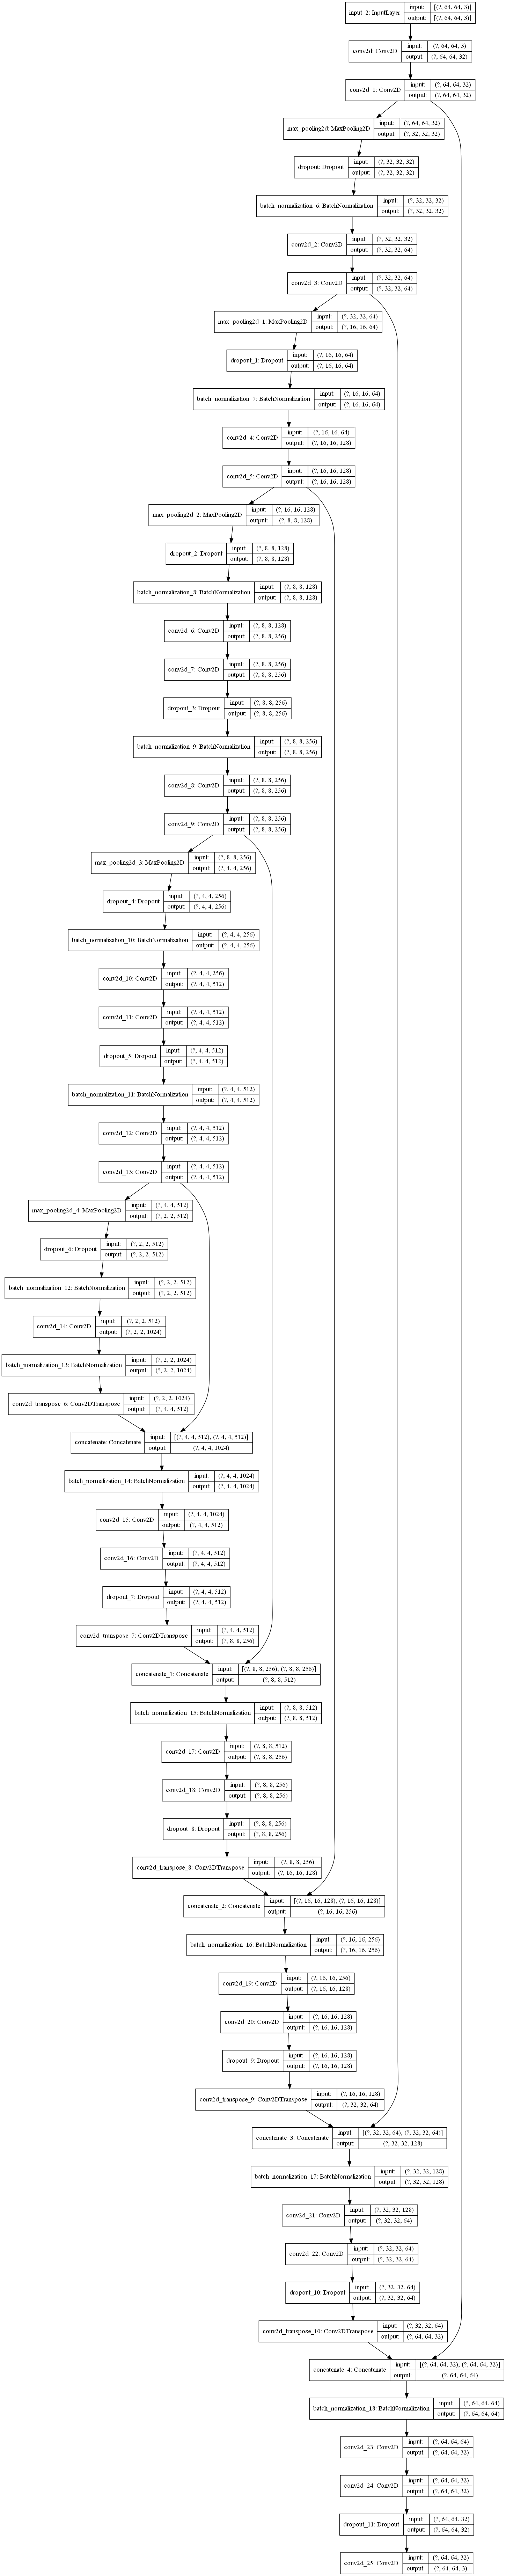

In [21]:
plot_model(model,to_file='D:/vision_impulse/model_'+str(name)+'.png',show_shapes=True,show_layer_names=True)

Now model needs to be compiled 

In [22]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Create callbacks namely early-stopping and modelcheckpoint

In [23]:
weights_path = 'D:/vision_impulse/weights/'
if not os.path.exists(weights_path):
    os.makedirs(weights_path)
    
file_path = os.path.join(weights_path+'model')
print(file_path)


D:/vision_impulse/weights/model


In [24]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

es = EarlyStopping(patience=100,monitor='val_loss',mode ='auto',restore_best_weights=True)
mc = ModelCheckpoint(filepath = file_path,monitor='val_loss',save_best_only=True)


### Training Metrics


In [25]:
batch_size= 8
steps_per_epoch = int(len(X_train)//batch_size)
epochs = 200

Start of Training Process

In [26]:
history = model.fit(X_train,y_train,steps_per_epoch = steps_per_epoch,validation_data=(X_valid,y_valid),epochs = epochs,callbacks = [es,mc])

Epoch 1/200
50/50 [==============================] - ETA: 0s - loss: 0.7095 - accuracy: 0.7106WARNING:tensorflow:From C:\Users\Dheeraj Reddy P\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: D:/vision_impulse/weights/model\assets
50/50 [==============================] - 28s 560ms/step - loss: 0.7095 - accuracy: 0.7106 - val_loss: 6.7961 - val_accuracy: 0.5654
Epoch 2/200
50/50 [==============================] - 21s 414ms/step - loss: 0.5248 - accuracy: 0.7872 - val_loss: 1.6766 - val_accuracy: 0.6980
Epoch 3/200
50/50 [==============================] - 21s 429ms/step - loss: 0.4987 - accuracy: 0.8002 - val_loss: 0.8746 - val_accuracy: 0.6885
Epoch 4/200
50/50 [======

Epoch 42/200
50/50 [==============================] - 11s 222ms/step - loss: 0.2166 - accuracy: 0.9166 - val_loss: 0.2503 - val_accuracy: 0.9007
Epoch 43/200
50/50 [==============================] - 11s 222ms/step - loss: 0.2181 - accuracy: 0.9153 - val_loss: 0.2375 - val_accuracy: 0.9028
Epoch 44/200
50/50 [==============================] - 11s 222ms/step - loss: 0.2259 - accuracy: 0.9111 - val_loss: 0.2412 - val_accuracy: 0.9060
Epoch 45/200
50/50 [==============================] - 11s 223ms/step - loss: 0.2214 - accuracy: 0.9144 - val_loss: 0.2333 - val_accuracy: 0.9094
Epoch 46/200
50/50 [==============================] - 20s 401ms/step - loss: 0.2219 - accuracy: 0.9144 - val_loss: 0.2089 - val_accuracy: 0.9160
Epoch 47/200
50/50 [==============================] - 11s 222ms/step - loss: 0.2233 - accuracy: 0.9136 - val_loss: 0.2198 - val_accuracy: 0.9124
Epoch 48/200
50/50 [==============================] - 11s 223ms/step - loss: 0.2017 - accuracy: 0.9213 - val_loss: 0.2254 - val_ac

50/50 [==============================] - 11s 222ms/step - loss: 0.1389 - accuracy: 0.9446 - val_loss: 0.3520 - val_accuracy: 0.9025
Epoch 95/200
50/50 [==============================] - 11s 222ms/step - loss: 0.1418 - accuracy: 0.9431 - val_loss: 0.2707 - val_accuracy: 0.9113
Epoch 96/200
50/50 [==============================] - 11s 222ms/step - loss: 0.1430 - accuracy: 0.9429 - val_loss: 0.2608 - val_accuracy: 0.9126
Epoch 97/200
50/50 [==============================] - 11s 222ms/step - loss: 0.1386 - accuracy: 0.9445 - val_loss: 0.2291 - val_accuracy: 0.9230
Epoch 98/200
50/50 [==============================] - 11s 223ms/step - loss: 0.1340 - accuracy: 0.9466 - val_loss: 0.3276 - val_accuracy: 0.9080
Epoch 99/200
50/50 [==============================] - 11s 222ms/step - loss: 0.1480 - accuracy: 0.9408 - val_loss: 0.2685 - val_accuracy: 0.9068
Epoch 100/200
50/50 [==============================] - 11s 222ms/step - loss: 0.1422 - accuracy: 0.9431 - val_loss: 0.2397 - val_accuracy: 0.91

50/50 [==============================] - 11s 224ms/step - loss: 0.1091 - accuracy: 0.9554 - val_loss: 0.2852 - val_accuracy: 0.9147
Epoch 151/200
50/50 [==============================] - 11s 223ms/step - loss: 0.1097 - accuracy: 0.9553 - val_loss: 0.3412 - val_accuracy: 0.9121
Epoch 152/200
50/50 [==============================] - 11s 223ms/step - loss: 0.1120 - accuracy: 0.9544 - val_loss: 0.2963 - val_accuracy: 0.9179
Epoch 153/200
50/50 [==============================] - 11s 223ms/step - loss: 0.1079 - accuracy: 0.9558 - val_loss: 0.2991 - val_accuracy: 0.9140
Epoch 154/200
50/50 [==============================] - 11s 223ms/step - loss: 0.1105 - accuracy: 0.9552 - val_loss: 0.3299 - val_accuracy: 0.9065
Epoch 155/200
50/50 [==============================] - 11s 222ms/step - loss: 0.1134 - accuracy: 0.9536 - val_loss: 0.3103 - val_accuracy: 0.9125
Epoch 156/200
50/50 [==============================] - 11s 222ms/step - loss: 0.1146 - accuracy: 0.9534 - val_loss: 0.2736 - val_accuracy:

Save the trained model weights 

In [27]:
model.save('D:/vision_impulse/weights/mymodel.h5')

The final step make predictions and visualize

In [28]:
y_pred =model.predict(X_test)

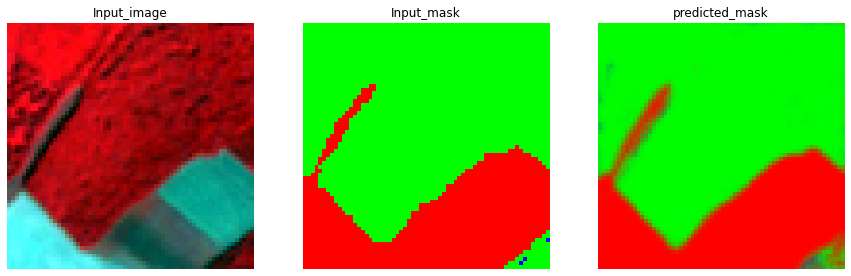

In [29]:
visualize([X_test[0],y_test[0],y_pred[0]])

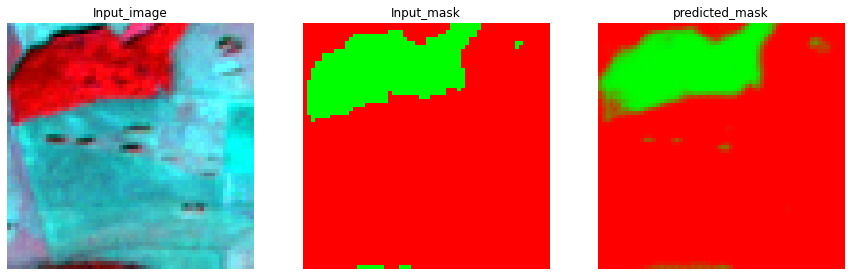

In [30]:
visualize([X_test[12],y_test[12],y_pred[12]])